<a href="https://colab.research.google.com/github/aksoym/Machine-Learning/blob/master/AksoyMProject_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UUM625 Project 3

## Application of Deep Autoencoders on Flight Data

### Prepared by Muhammet Aksoy

#### A template is used as the core structure of the following code. Template is provided by Mevlüt Uzun in the course UUM625 at ITU.


**Install Required Modules**

In [0]:
!pip3 install livelossplot

**Import Libraries**


In [0]:
#Keras libraries.
from keras.layers import Dense, Input
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras import backend as K
from livelossplot import PlotLossesKeras
import tensorflow as tf
tf.random.set_random_seed(27)

#Sklearn libraries.
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

#Google drive libraries.
from google.colab import drive
drive.mount("/content/drive")

#Numpy libraries.
import numpy as np
from numpy.random import shuffle
np.random.seed(27)

#Pandas libraries
import pandas as pd

#Matplotlib libraries.
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

**Read the Data**

In [0]:
flight_data = pd.read_pickle("/content/drive/My Drive/DeepLearning/Project_3/DataSet")
flight_data.head(3)

,Timestamp,Latitude (deg),Longitude (deg),Altitude (ft),Heading (deg),CAS (kt),Ground Speed (kt),Mach,Temp (C),Mass (kg),Apu Fuel (lb/hr),FF1 (lb/hr),FF2 (lb/hr),Throttle 1,Throttle 2,Course (deg),Wind Direction (deg),Wind Speed (kt),Flap (deg),Landing Gear,Speed Break,Zero Fuel Weight (lbs),Fuel Onboard (kg),Air Pressure (mb),Ground Speed Dot (kt/s2),Altitude Dot (ft/s),Heading Dot (deg/s),True Airspeed (m/s),True Airspeed Dot (m/s2),Gamma (rad),Drag (N),Thrust (N),Energy Share Factor,Acceleration Factor
0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0.0,32.017075,34.888712,-95.0,256.64,53.5,49.5,0.15,52.286212,NaN,11.0,8144.0,7952.0,71.0,71.0,259.453125,0.0,0.0,13.8375,1.0,-1.102259,934.0,1.70,184.615385,5.0,4.923077,0.0,54.233677,-0.710060,0.027668,NaN,NaN,-0.618799,-2.616033
2,0.0,32.017032,34.888454,-94.0,256.64,58.5,54.5,0.15,43.824291,NaN,11.0,8160.0,7936.0,71.0,71.0,259.804688,0.0,0.0,13.8375,1.0,-1.102259,935.0,1.75,189.538462,5.0,4.923077,0.0,53.523618,-0.650983,0.028035,NaN,NaN,-0.731540,-2.366980


**Data Preparation**

In [0]:
#Choose relevant features.
features = np.column_stack((flight_data["Altitude (ft)"], 
                            flight_data["Altitude Dot (ft/s)"], 
                            flight_data["Gamma (rad)"], 
                            flight_data["CAS (kt)"], 
                            flight_data["Mach"]
                           ))

#Choose a scaler.
robust = RobustScaler()
standard = StandardScaler()
minmax = MinMaxScaler()

#Scale the features.
fitted_scaler = minmax.fit( features )  
scaled_features = fitted_scaler.transform( features )

#Dimension of the input features.
print ("Dimension of the input features: " + str(scaled_features.shape))

Dimension of the input features: (69154, 5)


**Network**

In [0]:
#Clear session to get rid of the clutters of previous models.
K.clear_session()

#Desired output dimension of the encoder.
encoding_dim = 3

#Structure of the neural network.
encoder_input = Input(shape=(scaled_features.shape[1],))                      

encodingLayer_1 = Dense(4, activation= "tanh", 
                        kernel_initializer= "random_uniform")(encoder_input)
encoder_output = Dense(encoding_dim, activation= "tanh", 
                           kernel_initializer= "glorot_uniform")(encodingLayer_1)
decodingLayer_1 = Dense(4, activation= "tanh", 
                        kernel_initializer= "random_uniform")(encoder_output)
decoder_output = Dense(scaled_features.shape[1],
                           kernel_initializer= "random_uniform")(decodingLayer_1)

#Connecting the encoder.
encoder = Model(inputs=[encoder_input], outputs=[encoder_output])

#Connecting the autoencoder.
autoencoder = Model(inputs=[encoder_input], outputs=[decoder_output])

#Compiling the model.
desired_optimizer = optimizers.nadam()

autoencoder.compile(optimizer=desired_optimizer, loss="mae", metrics=["mse"])
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 15        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 16        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 25        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


**Arranging Callbacks**

In [0]:
best_model_name = "best_model" + ".hdf5"

best_model_path = "/content/drive/My Drive/DeepLearning/Project_3/" + best_model_name

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=10, min_lr=0.00001)

checkpoint = ModelCheckpoint(best_model_path, monitor='loss', verbose=1, save_best_only=True, period=1, mode='min')
early_stopping = EarlyStopping(monitor='loss', patience=20, verbose=0, mode='min', min_delta=0.0001)

**Model Training**

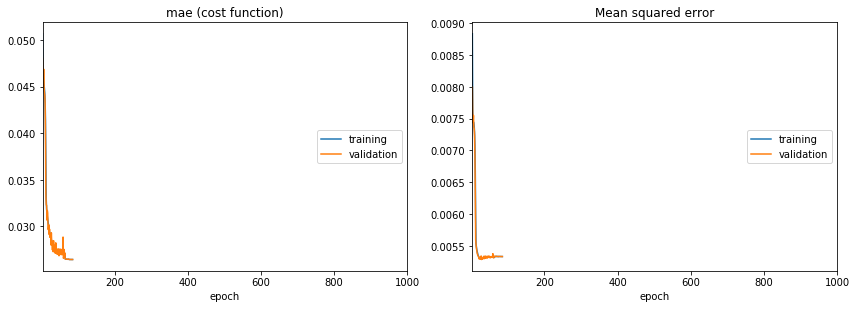

mae (cost function):
training   (min:    0.026, max:    0.181, cur:    0.026)
validation (min:    0.026, max:    0.075, cur:    0.026)

Mean squared error:
training   (min:    0.005, max:    0.088, cur:    0.005)
validation (min:    0.005, max:    0.017, cur:    0.005)


In [0]:
epoch_num = 1000
batch_size = 256

history = autoencoder.fit(scaled_features, scaled_features, 
                          batch_size=batch_size, epochs=epoch_num, shuffle=True, 
                          validation_data=(scaled_features, scaled_features), callbacks=[checkpoint, PlotLossesKeras(), reduce_lr, early_stopping])

**Load Best Model**

In [0]:
autoencoder = load_model(best_model_path)

**Extract the Encoder**

In [0]:
N = 2# The number of layer where you encode the data to your pre-defined dimension.

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[N].output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 15        
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________


**Predict with Encoder and Autoencoder**

In [0]:
encoded_features = encoder.predict(scaled_features)
autoencoded_features = autoencoder.predict(scaled_features)


**Comparing Autoencoded Features with Original Features**

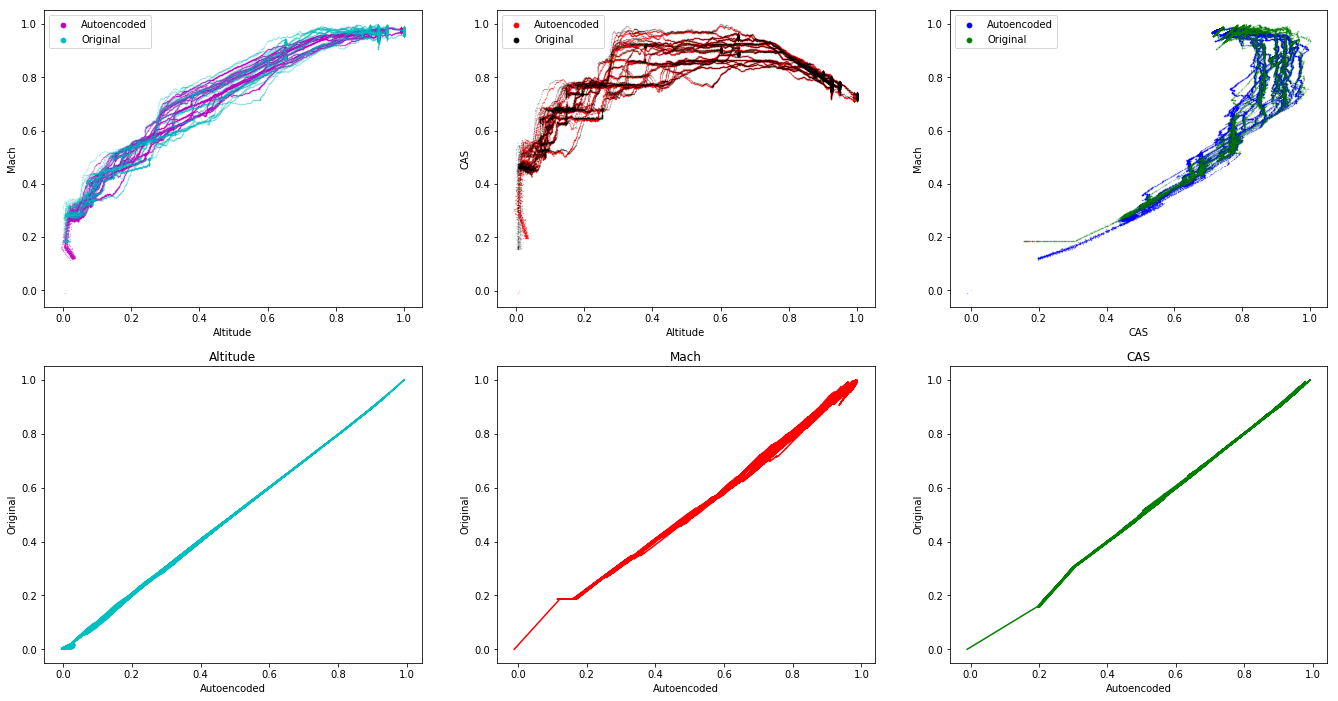

In [0]:
fig = plt.figure(figsize=(23, 12))
plt.subplot2grid((2, 3), (0, 0))
plt.scatter(autoencoded_features[:, 0], autoencoded_features[:, 4], alpha=0.5, s=0.1, c='m', label='Autoencoded')
plt.scatter(scaled_features[:, 0], scaled_features[:, 4], alpha=0.2, s=0.1, c='c', label='Original')
plt.xlabel('Altitude')
plt.ylabel('Mach')
leg = plt.legend(markerscale=15)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    

plt.subplot2grid((2, 3), (0, 1))
plt.scatter(autoencoded_features[:, 0], autoencoded_features[:, 3], alpha=0.5, s=0.1, c='r', label='Autoencoded')
plt.scatter(scaled_features[:, 0], scaled_features[:, 3], alpha=0.2, s=0.1, c='k', label='Original')
plt.xlabel('Altitude')
plt.ylabel('CAS')
leg = plt.legend(markerscale=15)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    

plt.subplot2grid((2, 3), (0, 2))
plt.scatter(autoencoded_features[:, 3], autoencoded_features[:, 4], alpha=0.5, s=0.1, c='b', label='Autoencoded')
plt.scatter(scaled_features[:, 3], scaled_features[:, 4], alpha=0.2, s=0.1, c='g', label='Original')
plt.xlabel('CAS')
plt.ylabel('Mach')
leg = plt.legend(markerscale=15)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
   
plt.subplot2grid((2, 3), (1, 0))
plt.plot(autoencoded_features[:, 0], scaled_features[:, 0], c='c')
plt.xlabel('Autoencoded')
plt.ylabel('Original')
plt.title('Altitude')
       
plt.subplot2grid((2, 3), (1, 1))
plt.plot(autoencoded_features[:, 4], scaled_features[:, 4], c='r')
plt.xlabel('Autoencoded')
plt.ylabel('Original')
plt.title('Mach')

plt.subplot2grid((2, 3), (1, 2))
plt.plot(autoencoded_features[:, 3], scaled_features[:, 3], c='g')
plt.xlabel('Autoencoded')
plt.ylabel('Original')
plt.title('CAS')
    
plt.show()

**Plotting the Encoded Data**

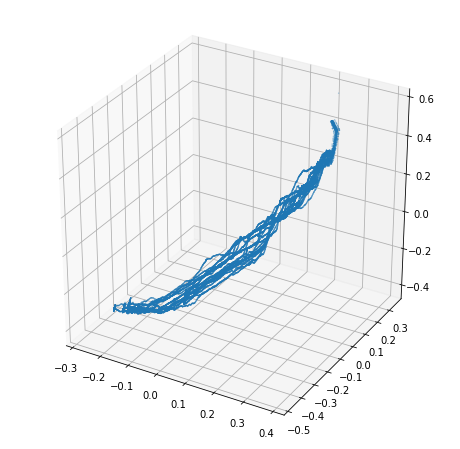

In [0]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(encoded_features[:, 0], encoded_features[:, 1], encoded_features[:, 2], s=0.1)
plt.show()

**Clustering the Encoded Data**

In [0]:
#DBSCAN.
db_scan = DBSCAN(eps=0.0541, min_samples=3500, n_jobs=-1, leaf_size=60)

#K-Means.
k_means = KMeans(n_clusters=4, n_init=20, tol=0.00001)

#Gaussian Mixture.
gaus = GaussianMixture(n_components=4, n_init=5, max_iter=200)

#Bayesian Gaussian Mixture.
bgaus = BayesianGaussianMixture(n_components=4, n_init=5, max_iter=200)


labels = gaus.fit_predict(encoded_features)

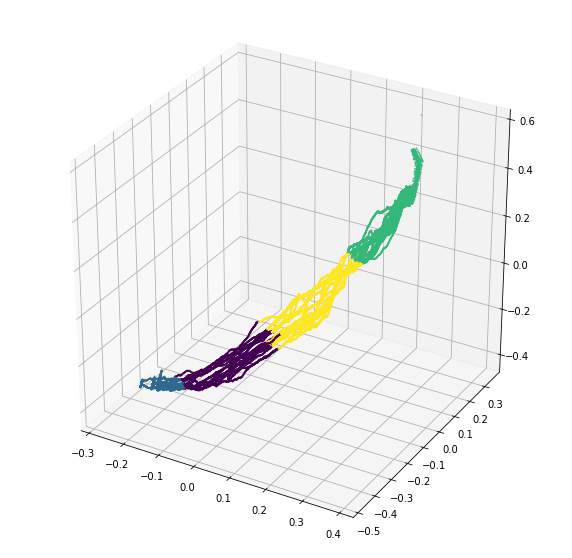

In [0]:
LABEL_COLOR_MAP = {-1: 'k',
                   0 : 'b',
                   1 : 'g',
                   2 : 'r',
                   3 : 'c',
                   4 : 'darkviolet',
                   5 : 'saddlebrown',
                   6 : 'darkorange',
                   7 : 'yellow',
                   8 : 'hotpink',
                   9 : 'lawngreen'}

label_color = [LABEL_COLOR_MAP[l] for l in labels]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(encoded_features[:, 0], encoded_features[:, 1], encoded_features[:, 2], c=labels, s=1, cmap='viridis')

plt.show()



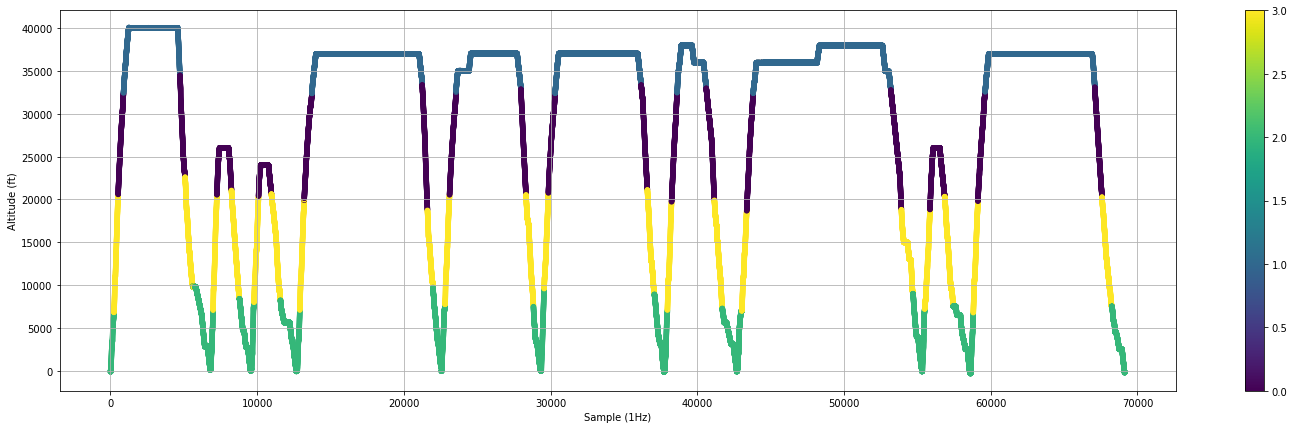

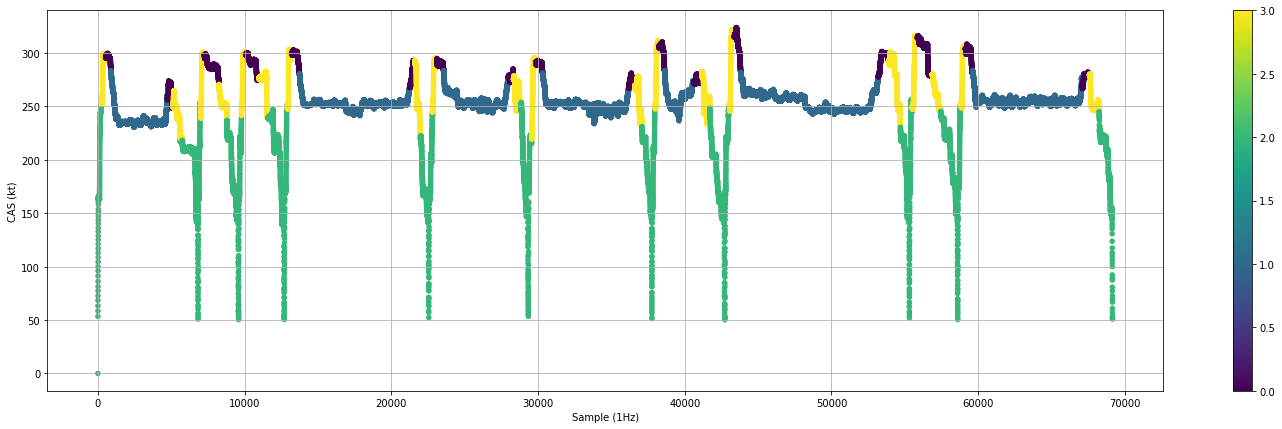

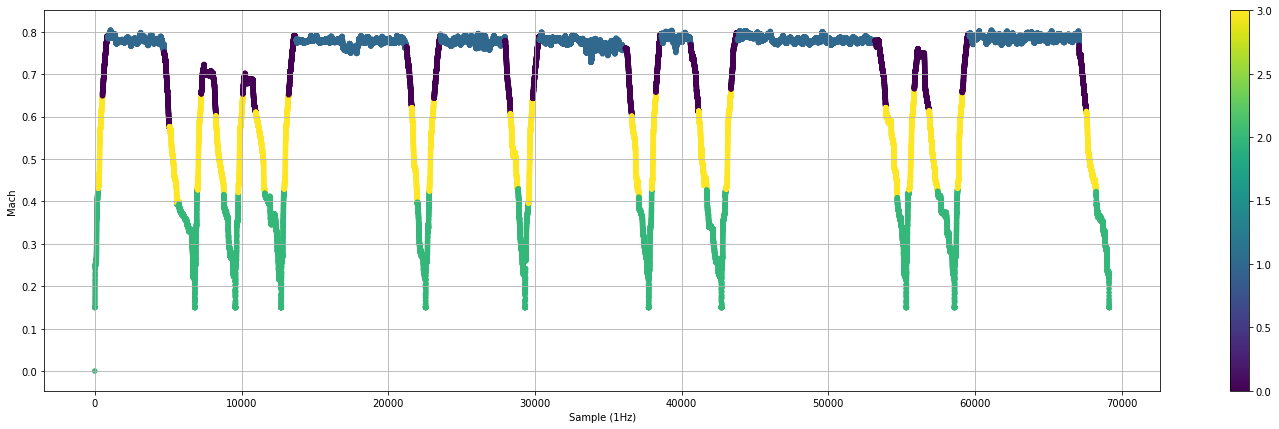

In [0]:
colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
cmap_name = 'my_list'

n_bin = len(np.unique(labels))
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=n_bin)

t = np.arange(0, flight_data['Altitude (ft)'].shape[0])

d_size = 20

plt.figure(figsize=(25,7))
plt.scatter(t, flight_data['Altitude (ft)'], s = d_size, c = labels, cmap='viridis')
plt.xlabel('Sample (1Hz)')
plt.ylabel('Altitude (ft)')
plt.grid()
plt.colorbar()



plt.figure(figsize=(25,7))
plt.scatter(t, flight_data['CAS (kt)'], s = d_size, c = labels, cmap='viridis')
plt.xlabel('Sample (1Hz)')
plt.ylabel('CAS (kt)')
plt.grid()
plt.colorbar()


plt.figure(figsize=(25,7))
plt.scatter(t, flight_data['Mach'], s = d_size, c = labels, cmap='viridis')
plt.xlabel('Sample (1Hz)')
plt.ylabel('Mach')
plt.grid()
plt.colorbar()


plt.show()

